Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp

This is rstanarm version 2.21.1

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

  options(mc.cores = parallel::detectCores())



         
            Neg   Pos
  Placebo 10365   156
  Vaccine 10544     7

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Wed Jun 23 13:16:45 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 21072
   Unobserved stochastic nodes: 2
   Total graph size: 42153
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
All chains have finished
Note: the model did not requ

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],1.26444e-02,0.014929250,0.01724510,1.495637e-02,0.0011750732,NA,5.896112e-06,0.5,39719,0.005346163,1.000044
theta[2],3.97043e-04,0.000906037,0.00151679,9.378713e-04,0.0002950191,NA,1.475095e-06,0.5,40000,0.000560000,1.000168
theta[3],8.95919e+01,93.921250000,97.34350000,9.369040e+01,2.0502915684,NA,1.020906e-02,0.5,40333,0.002266093,1.000273


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 3 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                             
            Lower95     Median  Upper95       Mean         SD Mode      MCerr
theta[1]   0.012659    0.01493 0.017243   0.014958   0.001176   -- 4.1374e-06
theta[2] 0.00039874 0.00090613 0.001517 0.00093744 0.00029446   -- 1.0404e-06
theta[3]     89.602      93.93   97.343     93.694      2.047   --  0.0072342
                                       
         MC%ofSD SSeff     AC.10   psrf
theta[1]     0.4 80786 0.0053462      1
theta[2]     0.4 80107   0.00056 1.0001
theta[3]     0.4 80067 0.0022661 1.0001

Total time taken: 1.2 minutes


,Parameter,MAP,CI,CI_low,CI_high,pd
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Posterior,94.39452,0.95,89.60197,97.34282,1


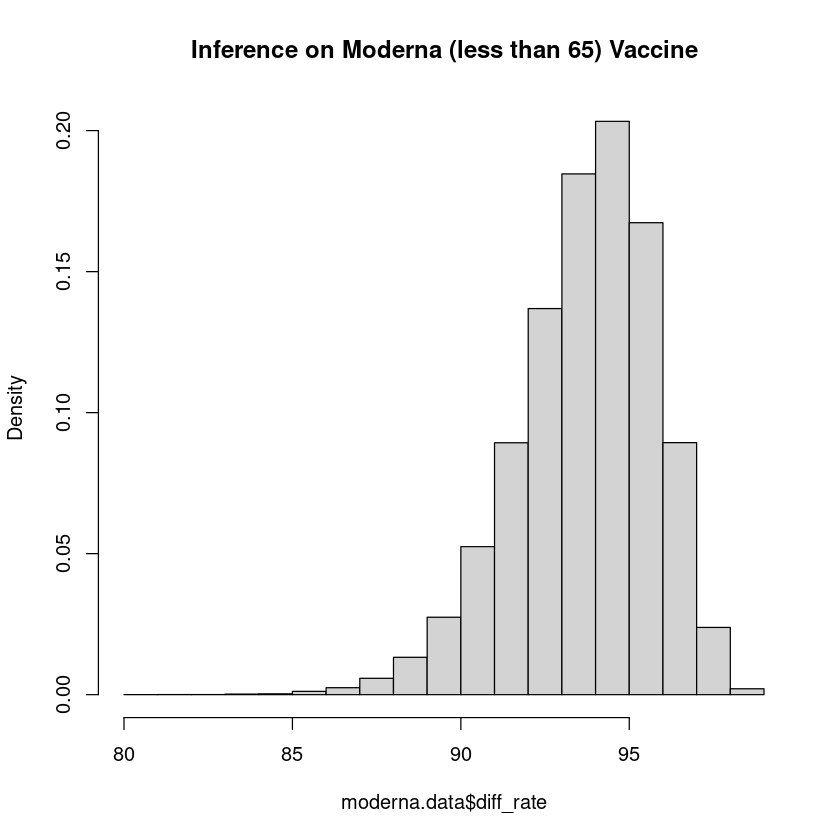

In [1]:
### age less than 65

library(rjags)
library(runjags)
library(R2jags)
library(tidybayes)
library(dplyr)
library(coda)
library(rstanarm)
library(plotrix)
library(dupiR)

tot_vaccine <- 10551
tot_placebo <- 10521
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 7
pos_placebo <- 156
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
moderna.tb <- tibble::tibble(tested = tested, patient=patient)
table(moderna.tb[[2]], moderna.tb[[1]])

dataList = list(
    tested = ifelse(moderna.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(moderna.tb$patient)),
    Ntot = nrow(moderna.tb) ,
    Nclass = nlevels(factor(moderna.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(3 , 100)    
    }
  theta[3] = (theta[1]-theta[2])/theta[1] * 100
  }"
writeLines(modelString , con="jags_Moderna_model.txt")

moderna_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(moderna_chains)
add.summary(moderna_chains)

moderna_res    <- tidybayes::tidy_draws(moderna_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

moderna.mcmc <- as.mcmc(moderna_res)
moderna.data <- as.data.frame(moderna.mcmc)

hist(moderna.data$diff_rate,freq=FALSE,main='Inference on Moderna (less than 65) Vaccine')

bayestestR::describe_posterior(moderna.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")

         
           Neg  Pos
  Placebo 3523   29
  Vaccine 3581    4

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Wed Jun 23 13:18:04 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 7137
   Unobserved stochastic nodes: 2
   Total graph size: 14283
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not re

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],5.84022e-03,0.008662010,0.0118390,0.008755271,0.0015453263,NA,7.726631e-06,0.5,40000,-0.002019827,1.000103
theta[2],6.62857e-04,0.001809675,0.0033539,0.001898224,0.0007162113,NA,3.581056e-06,0.5,40000,0.004689487,1.000115
theta[3],5.86123e+01,79.117450000,93.4442000,77.618590207,9.5248513390,NA,4.783285e-02,0.5,39652,0.004987473,1.000224


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 3 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                           
           Lower95    Median   Upper95      Mean         SD Mode      MCerr
theta[1] 0.0058375 0.0086607  0.011808 0.0087526  0.0015375   -- 5.4518e-06
theta[2] 0.0006579 0.0018083 0.0033463 0.0018975 0.00071412   -- 2.5321e-06
theta[3]    58.957    79.142    93.679    77.627     9.5007   --   0.033245
                                        
         MC%ofSD SSeff      AC.10   psrf
theta[1]     0.4 79537 -0.0020198      1
theta[2]     0.4 79541  0.0046895      1
theta[3]     0.3 81671  0.0049875 1.0001

Total time taken: 23.8 seconds


,Parameter,MAP,CI,CI_low,CI_high,pd
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Posterior,82.27911,0.95,58.95692,93.67919,0.99995


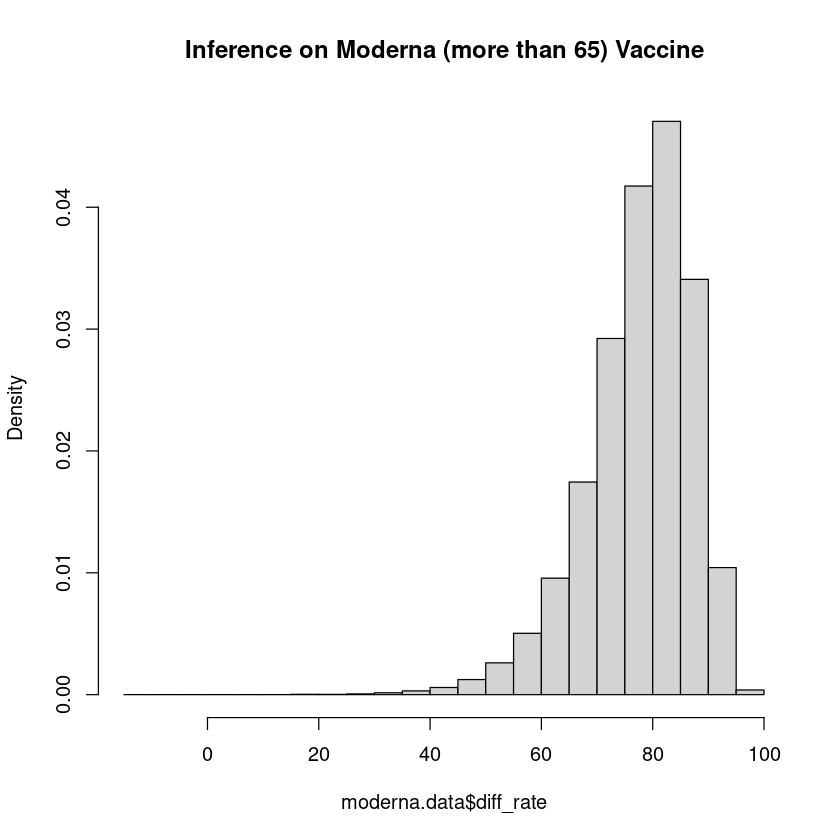

In [2]:
### age more than 65


tot_vaccine <- 3585
tot_placebo <- 3552
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 4
pos_placebo <- 29
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
moderna.tb <- tibble::tibble(tested = tested, patient=patient)
table(moderna.tb[[2]], moderna.tb[[1]])

dataList = list(
    tested = ifelse(moderna.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(moderna.tb$patient)),
    Ntot = nrow(moderna.tb) ,
    Nclass = nlevels(factor(moderna.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(3 , 100)    
    }
  theta[3] = (theta[1]-theta[2])/theta[1] * 100
  }"
writeLines(modelString , con="jags_Moderna_model.txt")

moderna_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(moderna_chains)
add.summary(moderna_chains)

moderna_res    <- tidybayes::tidy_draws(moderna_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

moderna.mcmc <- as.mcmc(moderna_res)
moderna.data <- as.data.frame(moderna.mcmc)

hist(moderna.data$diff_rate,freq=FALSE,main='Inference on Moderna (more than 65) Vaccine')

bayestestR::describe_posterior(moderna.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")